In this notebook, we go through clustering methods over correlation distance matrix,
$d_{i, j} = \sqrt{\frac{1}{2} (1 - \rho_{i, j})}$. Especially, we try out k-means clustering. In k-means algorithm, you need to pick up the number of clusters, K, in advance. To tune this parameter, we introduce clustering quality metric, silhouette coefficient,
$$S_i = \frac{b_i - a_i}{max\{a_i, b_i\}}, \forall i = 1, ..., N$$
, where $b_i$ and $a_i$ are average distance from different cluster points and the same cluster points.

If clustering is completly at random, these two distance would be closer, so $S_i$ would be around zero on the average. The better quality, the close to 1 the metric becomes. To aggregate value on each point, we use the following
$$q = \frac{Mean[S_i]}{Std[S_i]}$$

Our clustering algorithm is breifly the following:
1. Find the best kmeans over 1-K cluster numbers
2. Iterate with different initialization
3. Try further 1 and 2 on set of clusters: $\{q_k | q_k < q k=1, ..., K\}$

Step 1 and 2 are implemented as `cluster_kmeans_base`. Step 1-3 are implemented as `cluster_kmeans_top`. 

The detail of implementations will be found at finance_ml/clustering.py.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Experiments on Rnaomd block Correlation Matrices

We generate correlation matrix, where strong correlation only within the same block.

In [2]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=False, sigma=.1)
print(x.shape)
x.head()

(100, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.993965,0.993464,0.993571,0.510621,0.508843,0.508265,0.508875,0.509013,0.509173,...,0.481232,0.480726,0.481383,0.518833,0.520815,0.518341,0.521465,0.521156,0.522932,0.523179
1,0.993965,1.000000,0.993732,0.993753,0.510269,0.508521,0.507734,0.508478,0.508515,0.508806,...,0.480773,0.480306,0.480937,0.518611,0.520482,0.518015,0.521201,0.520798,0.522728,0.522662
2,0.993464,0.993732,1.000000,0.993438,0.508830,0.507006,0.506169,0.507073,0.507070,0.507473,...,0.479456,0.478895,0.479444,0.517049,0.519057,0.516637,0.519763,0.519325,0.521079,0.521329
3,0.993571,0.993753,0.993438,1.000000,0.509752,0.508085,0.507269,0.507955,0.508210,0.508312,...,0.480279,0.479796,0.480404,0.518007,0.519894,0.517379,0.520694,0.520176,0.522157,0.522206
4,0.510621,0.510269,0.508830,0.509752,1.000000,0.993700,0.993487,0.993750,0.993858,0.993613,...,0.487703,0.487043,0.487878,0.525923,0.527959,0.525286,0.528716,0.528174,0.530119,0.530234


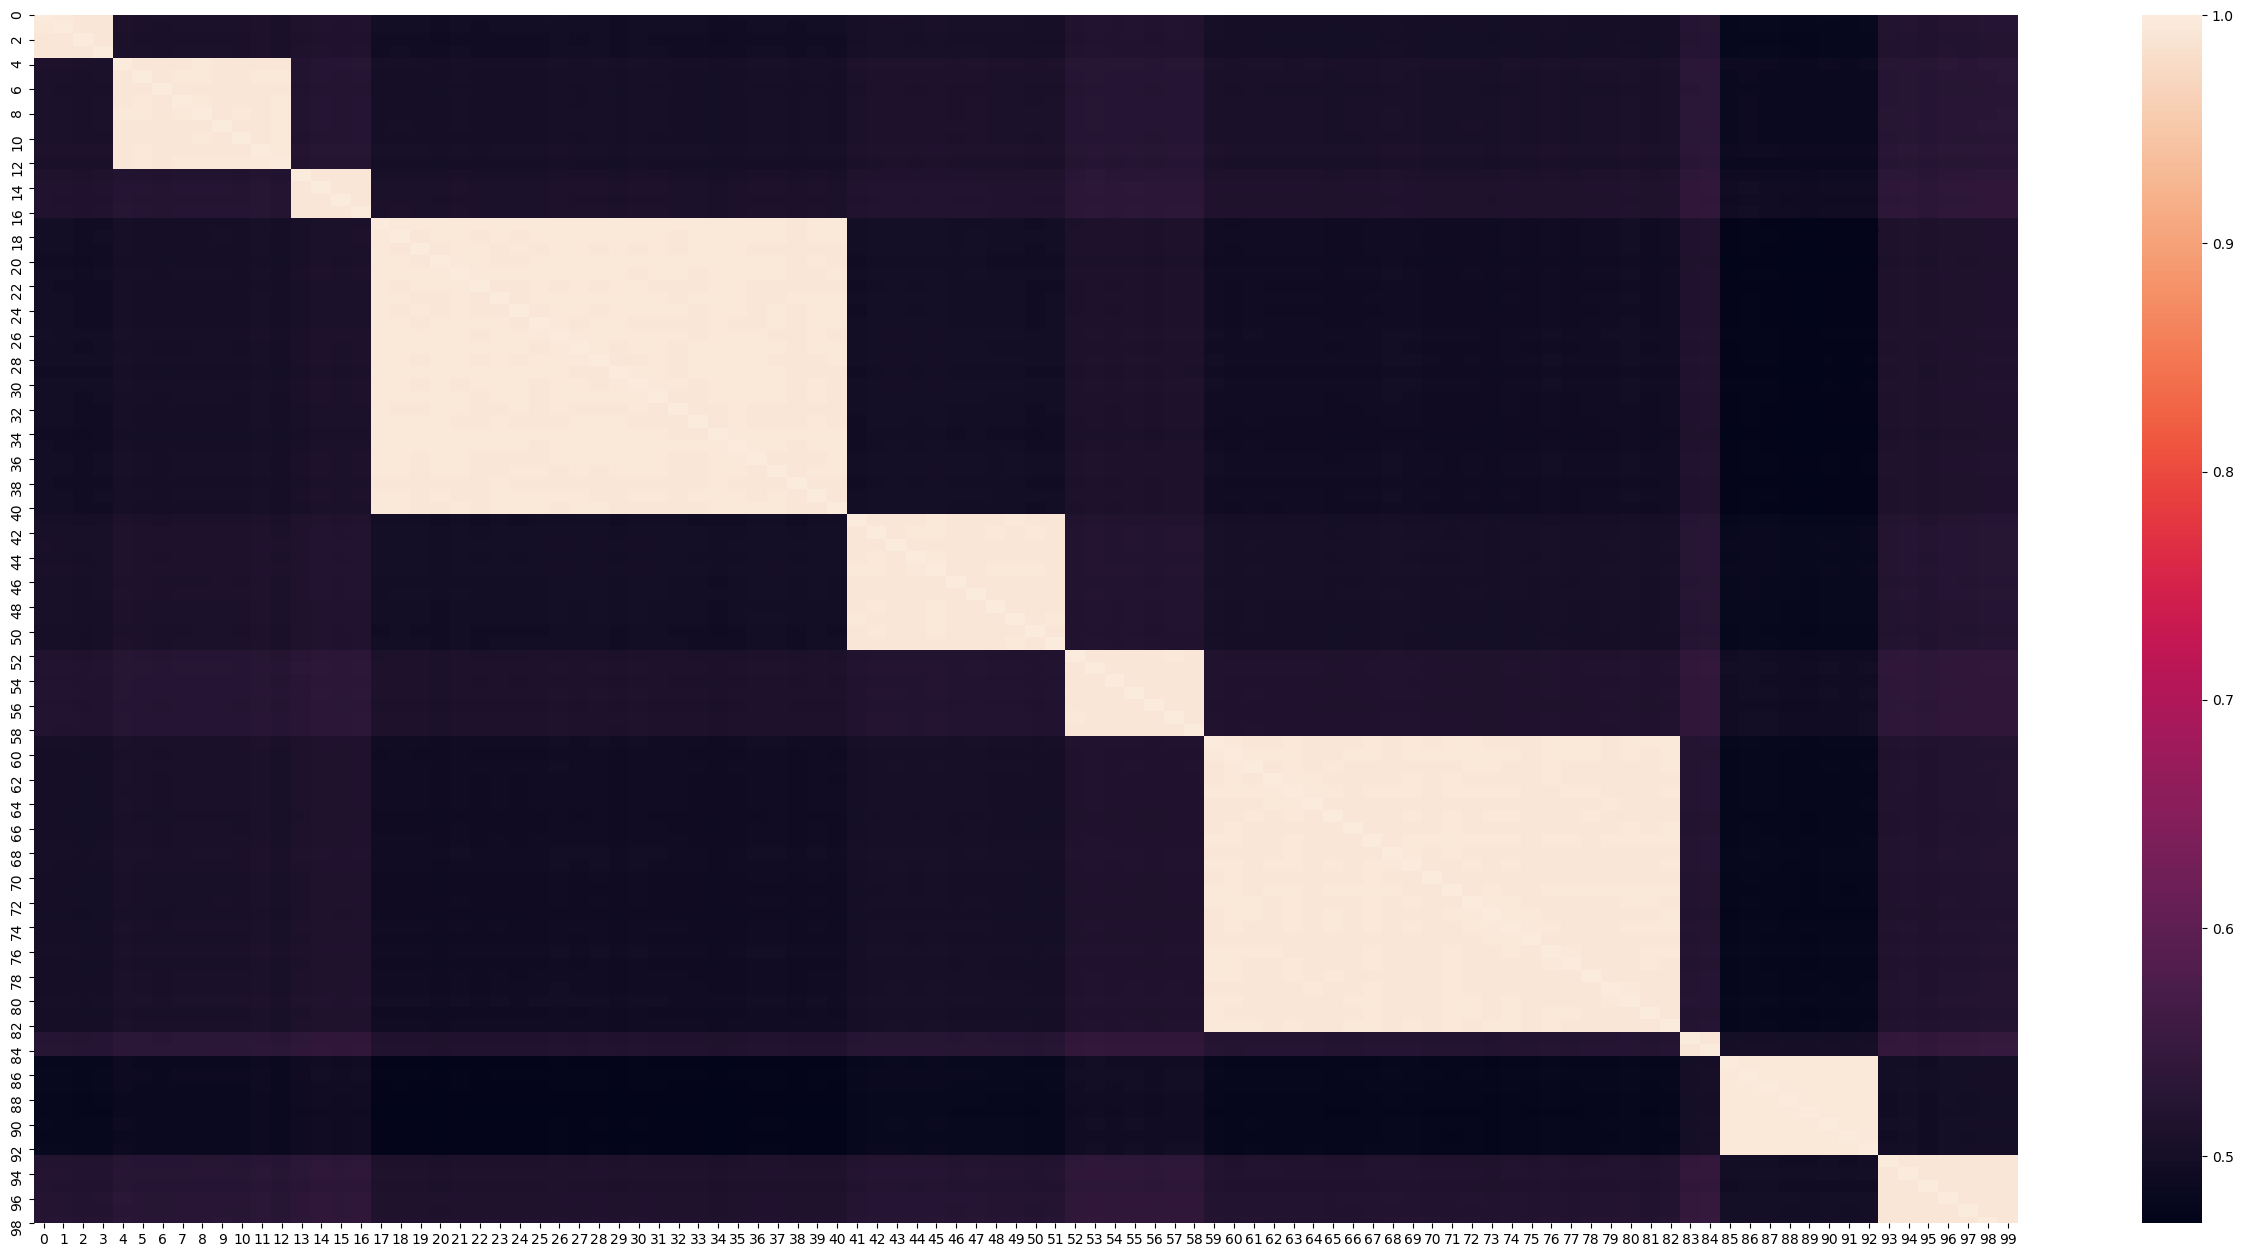

In [3]:
import seaborn as sns

sns.heatmap(x);

Before shuffling, you see several blocks in the correlation matrix.

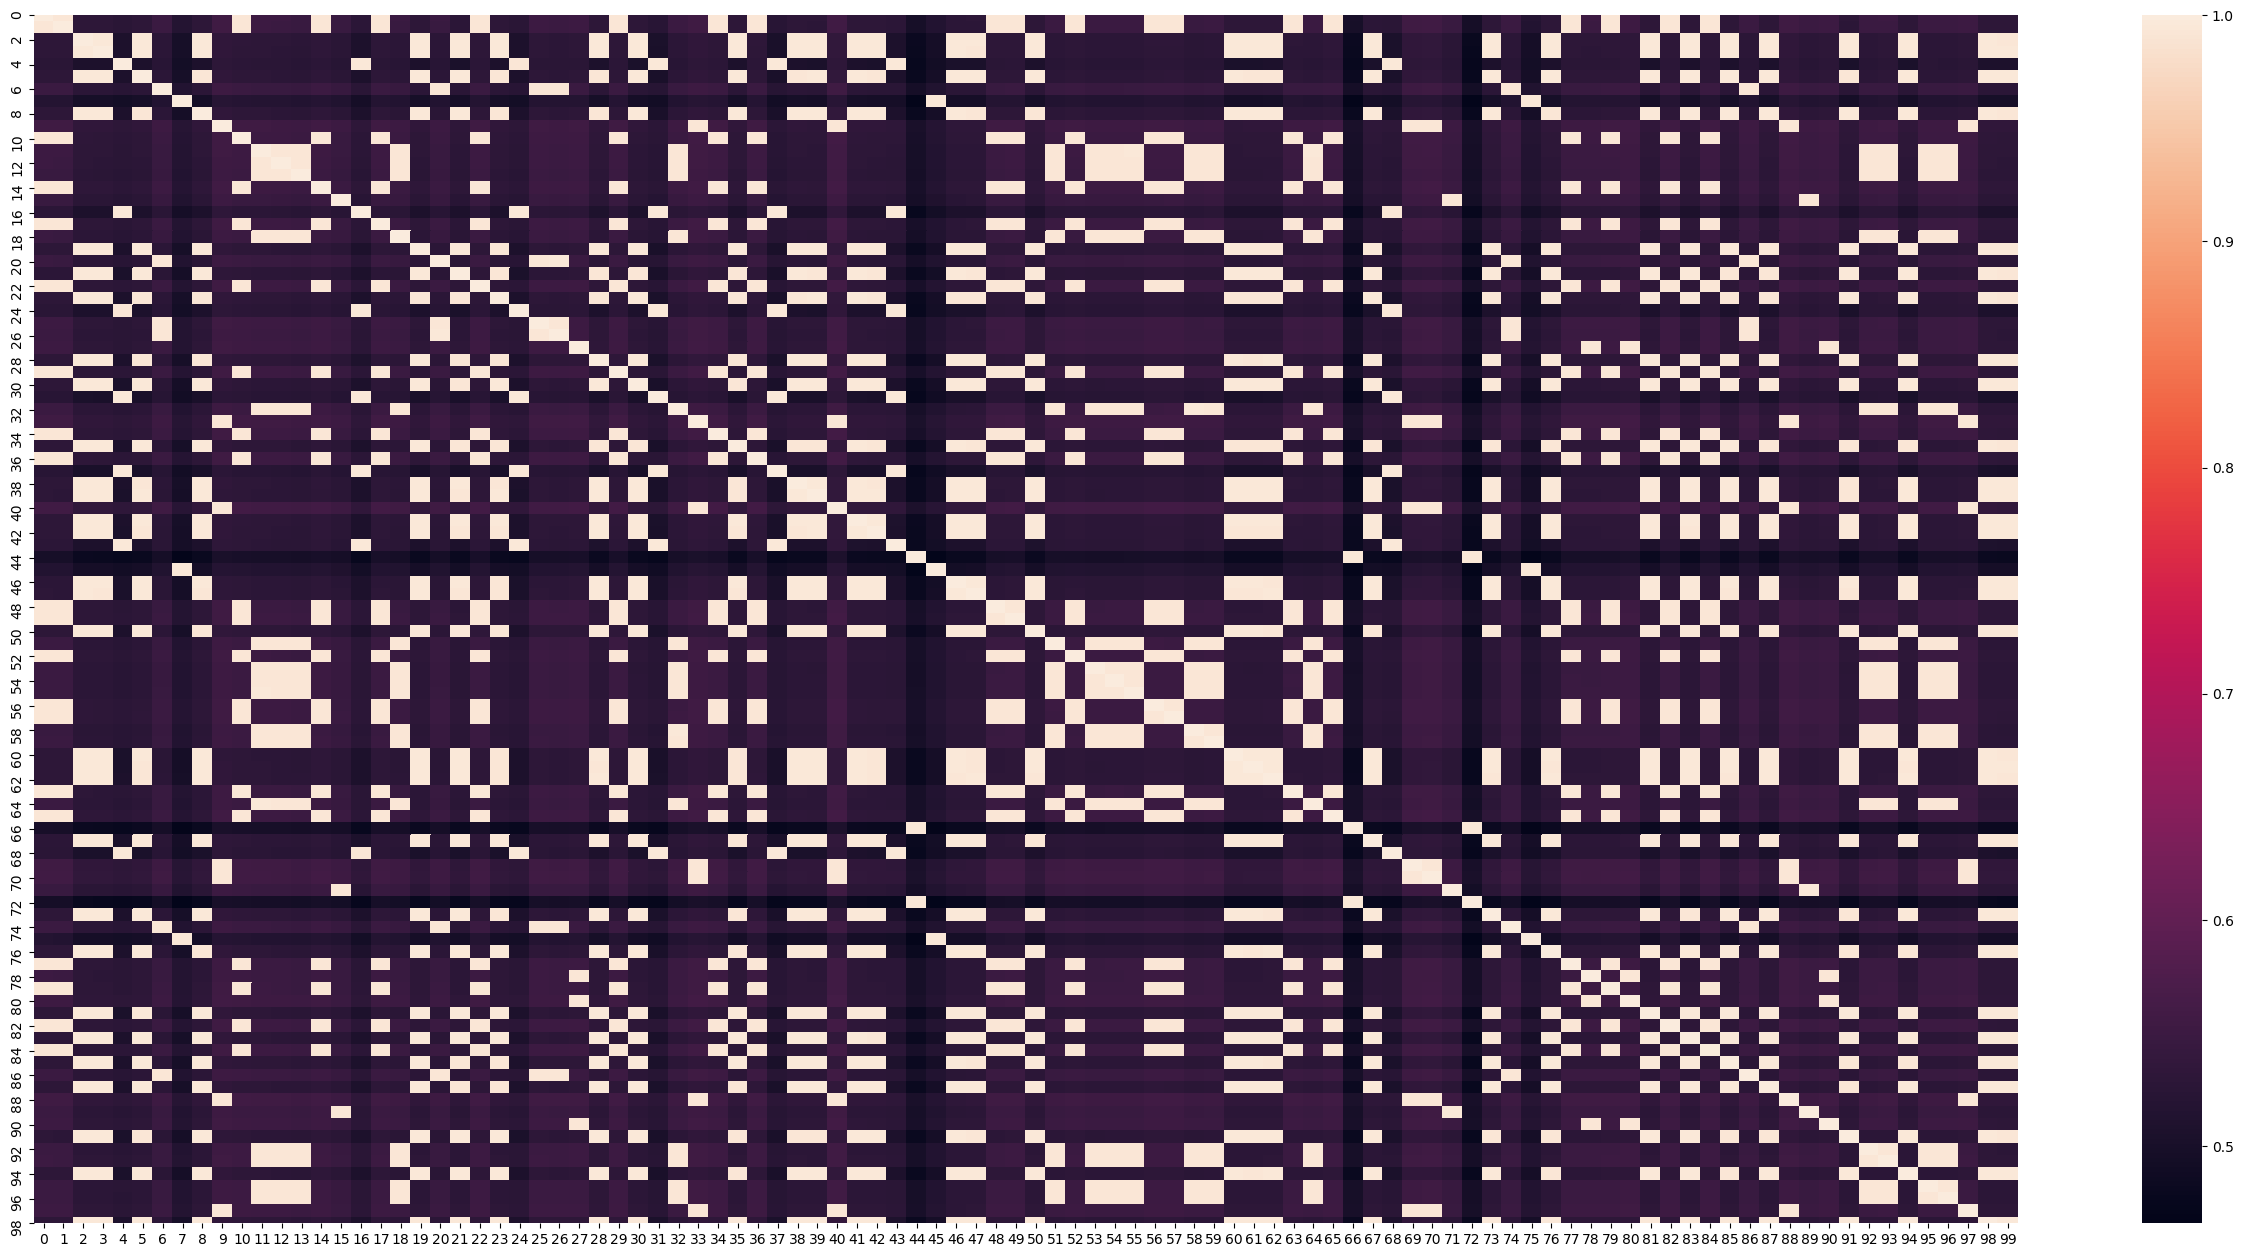

In [4]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=True, sigma=.1)
sns.heatmap(x);

Let's re-find clusters from this matrix.

The number of clusters: 10
{0: [0, 1, 10, 14, 17, 22, 29, 34, 36, 48, 49, 52, 56, 57, 63, 65, 77, 79, 82, 84], 1: [2, 3, 5, 8, 19, 21, 23, 28, 30, 35, 38, 39, 41, 42, 46, 47, 50, 60, 61, 62, 67, 73, 76, 81, 83, 85, 87, 91, 94, 98, 99], 2: [4, 16, 24, 31, 37, 43, 68], 3: [44, 66, 72], 4: [7, 45, 75], 5: [11, 12, 13, 18, 32, 51, 53, 54, 55, 58, 59, 64, 92, 93, 95, 96], 6: [9, 33, 40, 69, 70, 88, 97], 7: [6, 20, 25, 26, 74, 86], 8: [27, 78, 80, 90], 9: [15, 71, 89]}


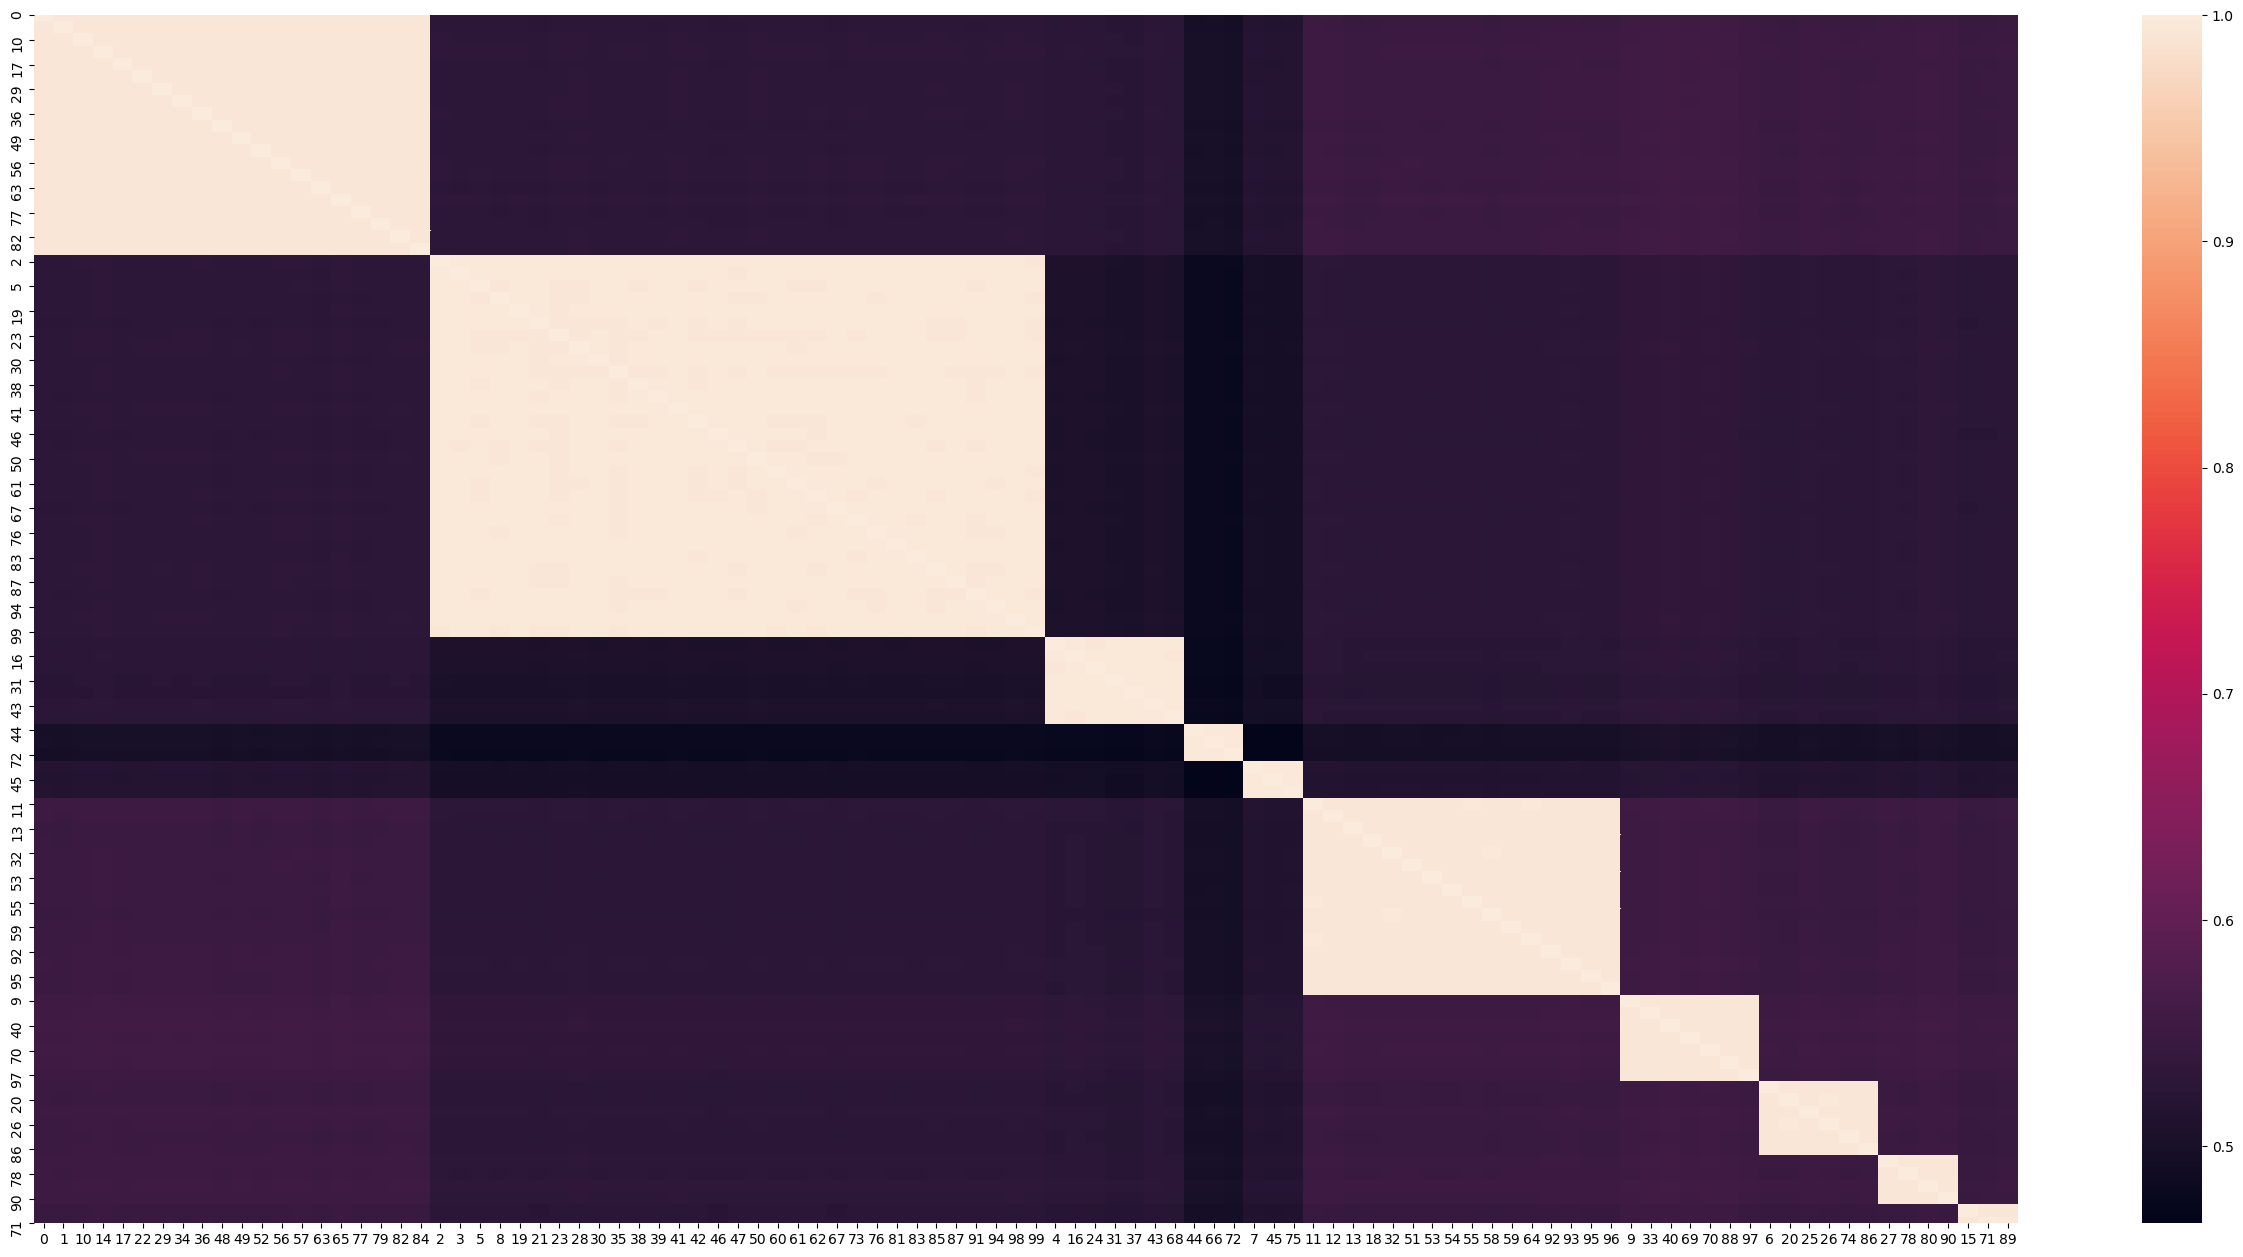

In [6]:
from finance_ml.clustering import cluster_kmeans_top, cluster_kmeans_base

corr1, clstrs1, silh1 = cluster_kmeans_top(x, 20, n_init=10)
print(f"The number of clusters: {len(clstrs1)}")
print(clstrs1)
sns.heatmap(corr1);

# Stability of the number of clusters

Estimating the number of clusters involves stochasticity. So, we estimate its stability.

In [15]:
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook

from finance_ml.experiments import get_random_block_corr
from finance_ml.clustering import cluster_kmeans_base, cluster_kmeans_top


n_iter = 50
N = 100
KN_ratio = np.linspace(0.1, 0.5, 5)
top_data = list()
data = list()
for i in tqdm_notebook(range(n_iter)):
    for ratio in KN_ratio:
        n_blocks = max(2, int(round(ratio * N)))
        x = get_random_block_corr(N, n_blocks=n_blocks, is_shuffle=False, sigma=1)
        corr1, clstrs1, silh1 = cluster_kmeans_top(x, 20)
        est_n_blocks = len(clstrs1)
        top_data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
        corr1, clstrs1, silh1 = cluster_kmeans_base(x, 20)
        est_n_blocks = len(clstrs1)
        data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
data = pd.DataFrame(data)
top_data = pd.DataFrame(top_data)

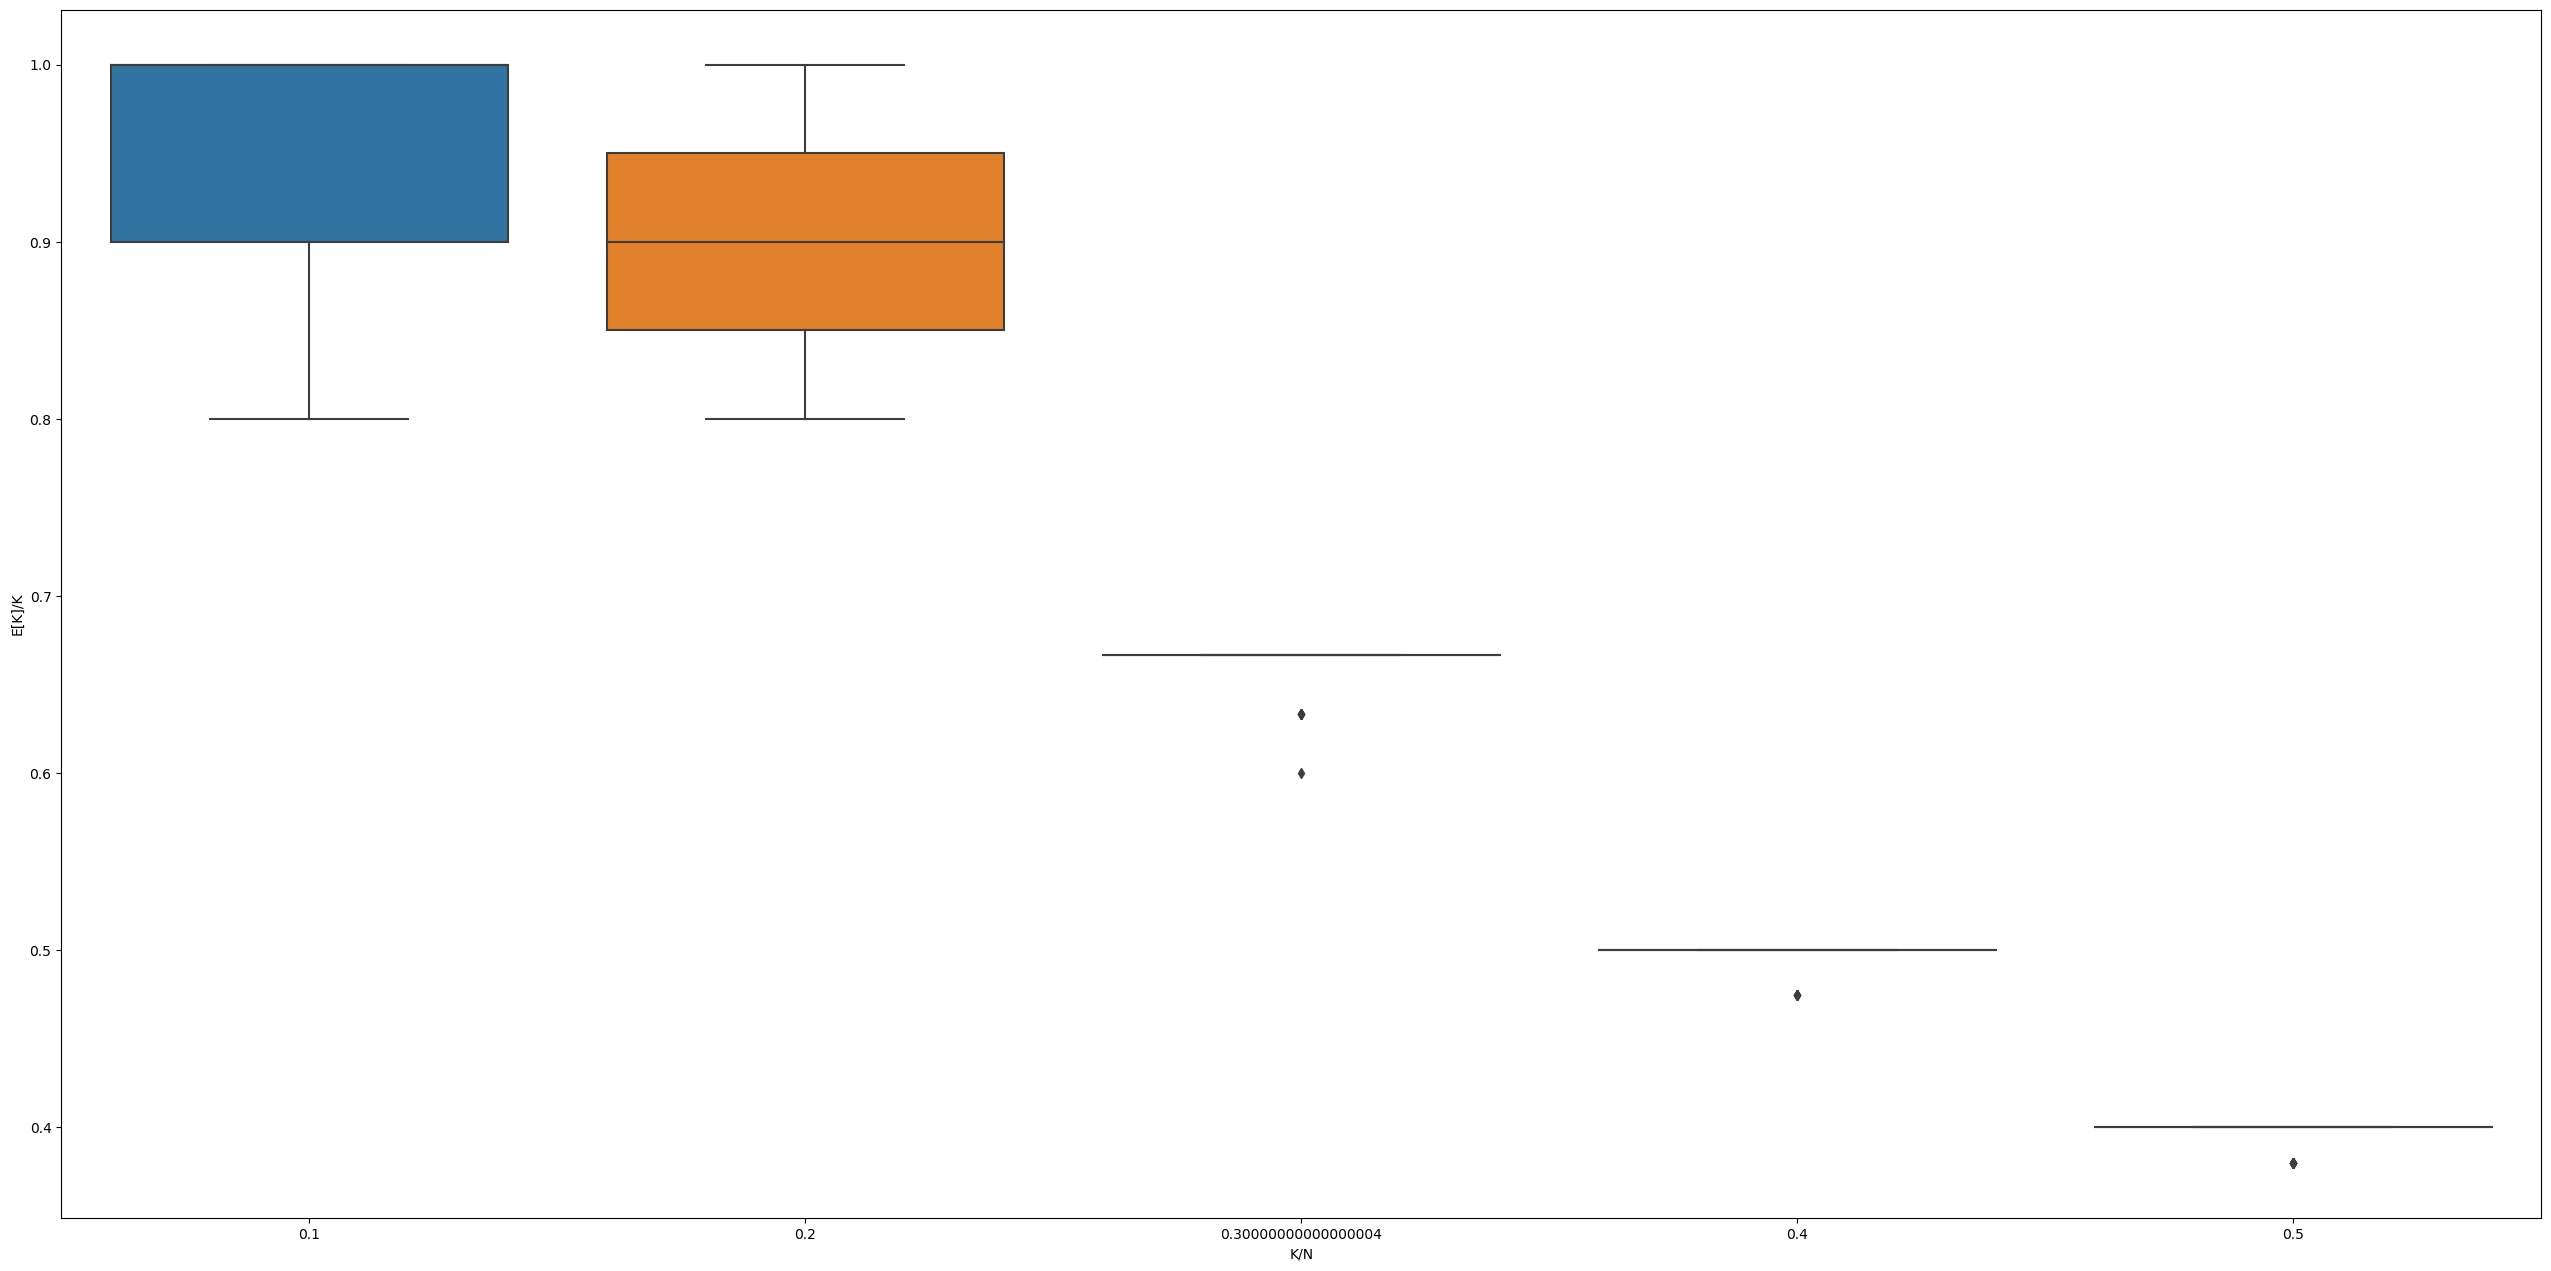

In [16]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=data);

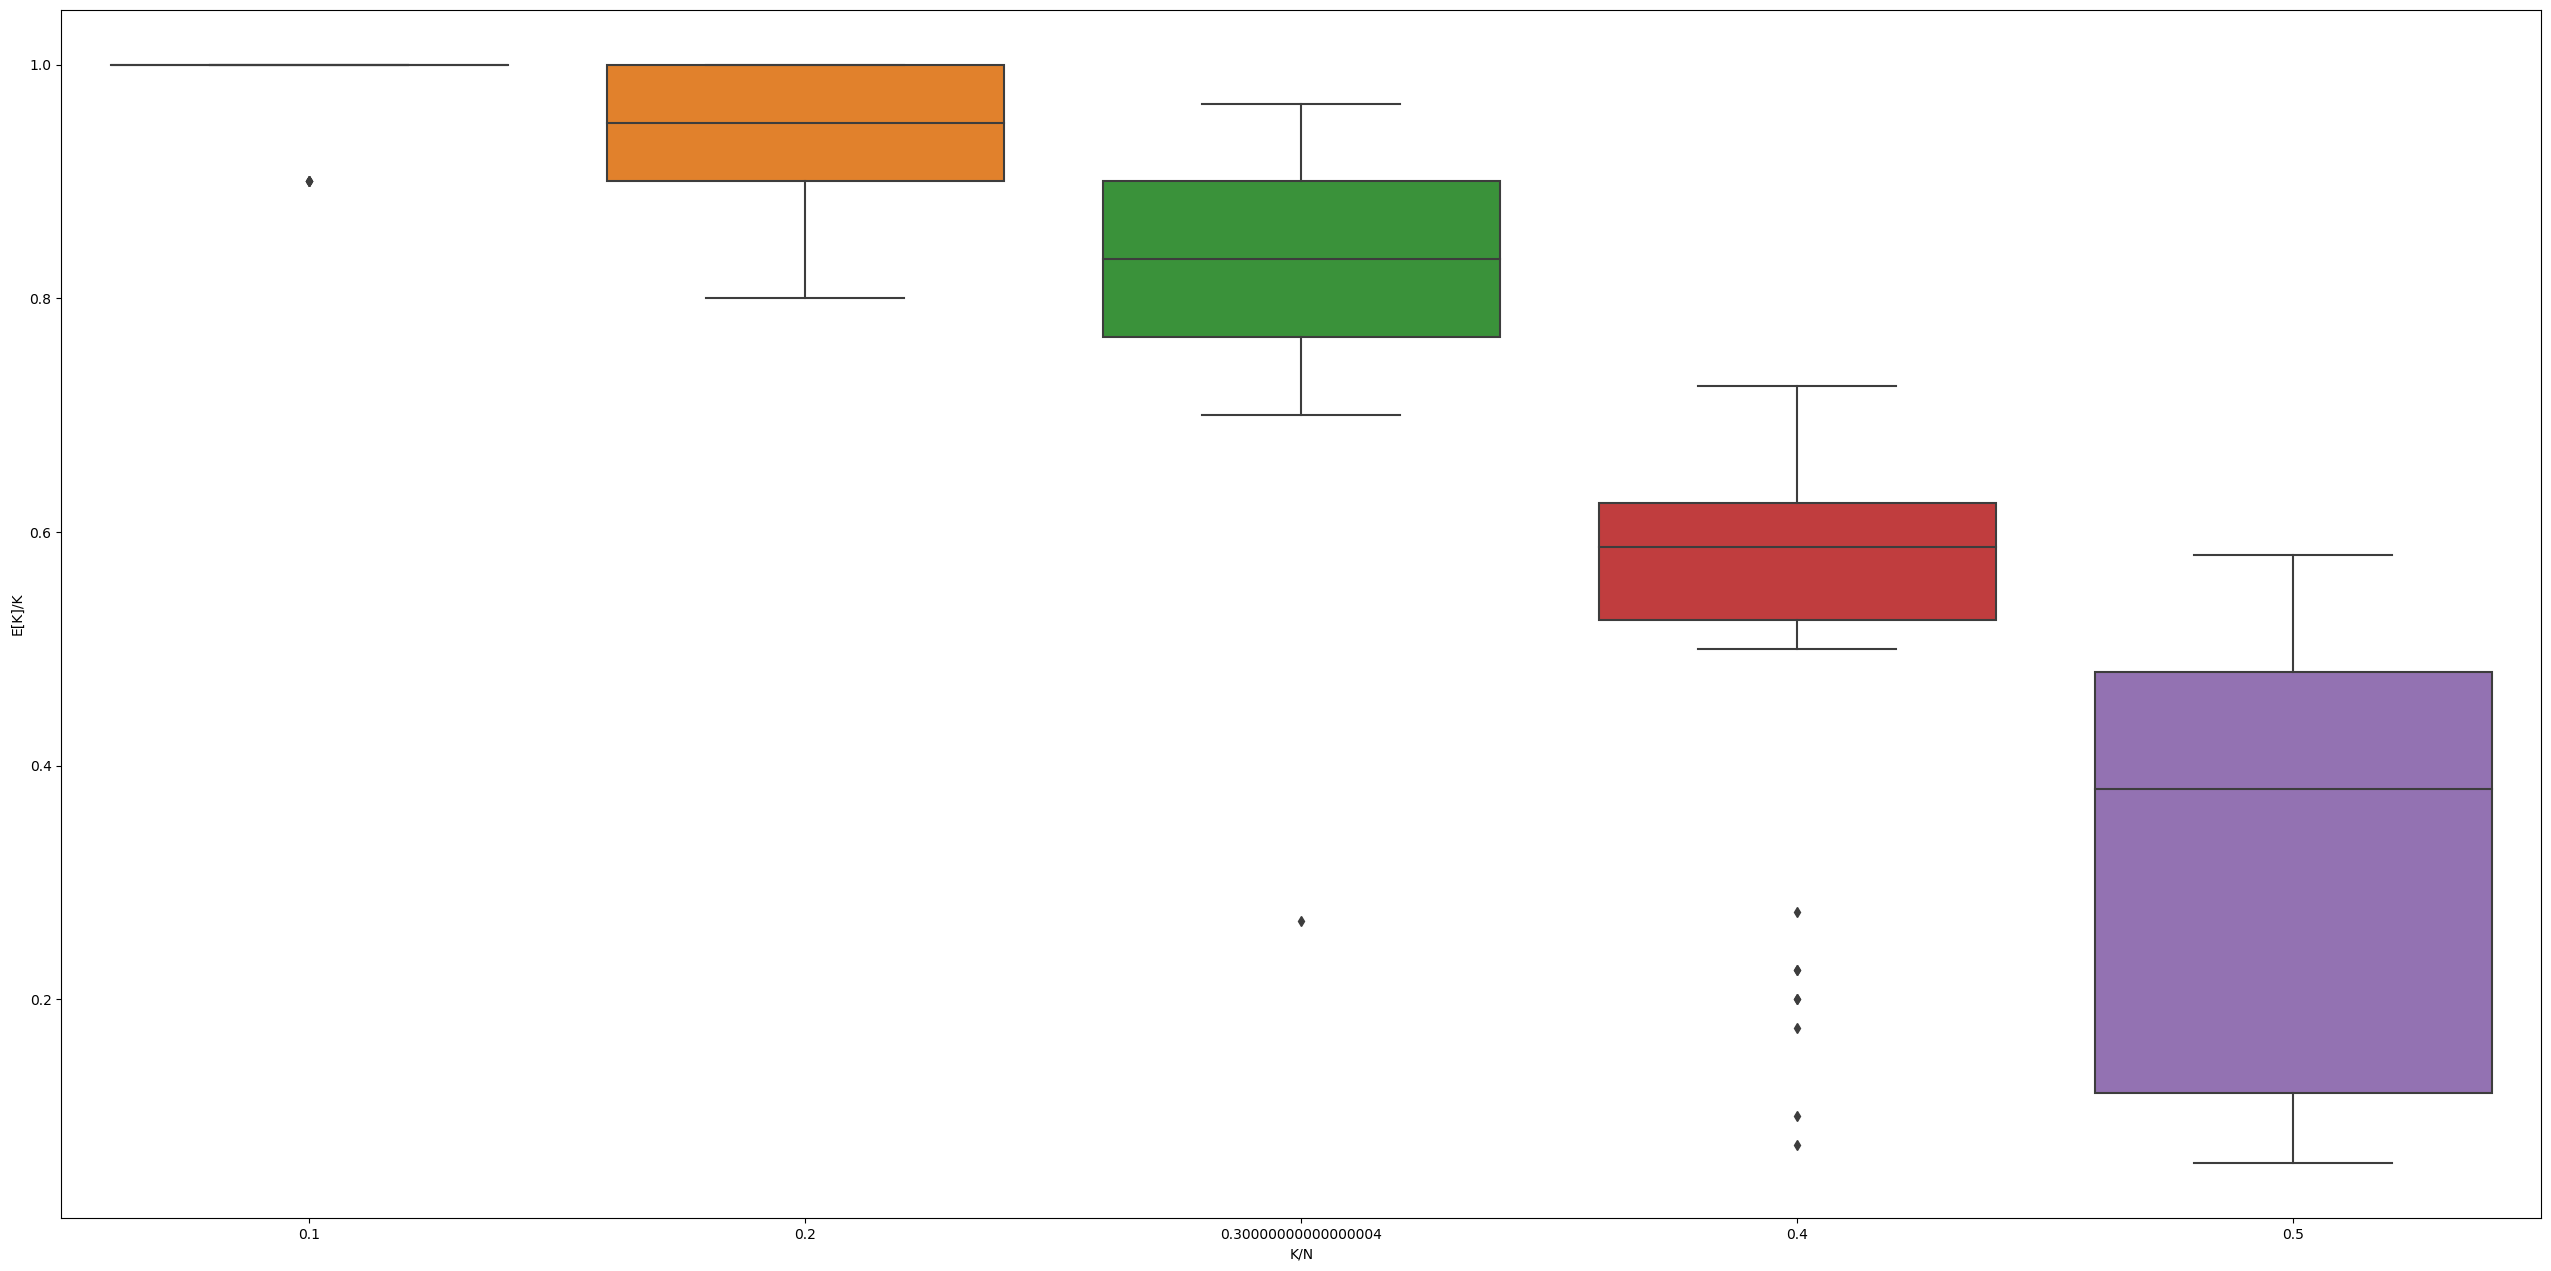

In [17]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=top_data);